In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

## Create the dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.MNIST(root='../VAE_MNIST/data', download=False, transform=transform)

In [3]:
dataset[0][0].shape

torch.Size([1, 28, 28])

## Define the GAN

<ol>
<li>Implement a GAN</li>
<li>For the generator, pass the class label as one hot vectors to an embeddings module and append it to the input</li>
<li>For the discriminator, append it to the FC layer input</li>
<ol>

In [4]:
class CGANGenerator(nn.Module):
    def __init__(self, z_dim=100, embeddings_size=10, embeddings_dim=4):
        super(CGANGenerator, self).__init__()
        self.z_dim = z_dim
        self.cls_embeddings = nn.Embedding(num_embeddings=embeddings_size, embedding_dim=embeddings_dim)
        self.upsample_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    
    def forward(self, x, cls_labels):
        embedding = self.cls_embeddings(cls_labels).view(-1, 4)
        out = torch.cat((x, embedding), dim=1).view(-1, self.z_dim, 1, 1)
        out = self.upsample_layers(out)
        return out

In [10]:
class CGANDiscriminator(nn.Module):
    def __init__(self, embeddings_size=10, embeddings_dim=28):
        super(CGANDiscriminator, self).__init__()
        self.cls_embeddings = nn.Embedding(num_embeddings=embeddings_size, embedding_dim=embeddings_dim)
        self.downsample_layers = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.linear = nn.Linear(64*3*3, 1)
    
    def forward(self, x, cls_labels):
        label_embs = self.cls_embeddings(cls_labels).unsqueeze(3)
        label_embs = label_embs.expand(x.size(0), 1, 28, 28)
        x = torch.cat((x, label_embs), dim=1)
        out = self.downsample_layers(x)
        out = torch.flatten(out, start_dim=1)
        out = self.linear(out)
        return nn.Sigmoid()(out)

## Define the training procedure

In [11]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
Z_DIM = 100 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
K_STEPS = 1

In [12]:
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
# Model
cgan_generator = CGANGenerator().to(DEVICE)
cgan_discriminator = CGANDiscriminator().to(DEVICE)

# Loss function
loss_fn = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(cgan_generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_d = optim.Adam(cgan_discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Fixed noise for generating consistent sample images during training
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(DEVICE)

In [14]:
for epoch in range(EPOCHS):
    loop = tqdm(dataloader, leave=True)  # tqdm for progress tracking
    for batch_idx, (real, classes) in enumerate(loop):
        classes = classes.view(-1, 1)
        real, classes = real.to(DEVICE),classes.to(DEVICE)
        for _ in range(K_STEPS):
            noise = torch.randn(BATCH_SIZE, Z_DIM-4).to(DEVICE)
            fake = cgan_generator(noise, classes)

            disc_real = cgan_discriminator(real, classes).view(-1)
            disc_fake = cgan_discriminator(fake.detach(), classes).view(-1)

            loss_d_real = loss_fn(disc_real, torch.ones_like(disc_real))
            loss_d_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))

            loss_d = (loss_d_real + loss_d_fake)/2

            optimizer_d.zero_grad()
            loss_d.backward()
            optimizer_d.step()
        
        # Repeat to update generator
        noise = torch.randn(BATCH_SIZE, Z_DIM-4).to(DEVICE)
        fake = cgan_generator(noise, classes)
        
        disc_fake = cgan_discriminator(fake, classes).view(-1)
        
        loss_g = loss_fn(disc_fake, torch.ones_like(disc_fake))
        
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # Update tqdm description
        loop.set_description(f'Epoch [{epoch}/{EPOCHS}]')
        loop.set_postfix(loss_d=loss_d.item(), loss_g=loss_g.item())
    

Epoch [9/10]: 100%|██████████| 1875/1875 [00:51<00:00, 36.34it/s, loss_d=0.414, loss_g=1.86] 


## Generate Images

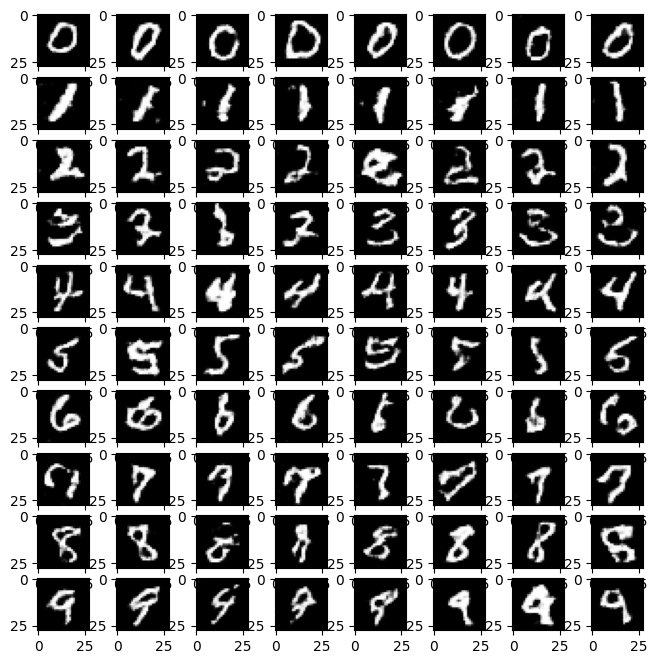

In [30]:
# Generate images for each digit
num_images_per_digit = 8
fig,axes = plt.subplots(10, 8, figsize=(8,8))

for i in range(10):
    noise_samples = torch.randn(num_images_per_digit, Z_DIM-4).to(DEVICE)
    classes = torch.tensor([i]*num_images_per_digit).to(DEVICE)
    images = cgan_generator(noise_samples, classes)
    for j in range(num_images_per_digit):
        axes[i, j].imshow(images[j][0].cpu().detach().numpy(), cmap='gray')

plt.show()    